In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_cosine_schedule_with_warmup

/tmp/ipykernel_772733/359250920.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v2'
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
TOKENIZER_ID = 'beomi/KcELECTRA-base-v2022'
SEED = 42
USE_RANDOM_SEED = True
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.05
EARLY_STOPPING_PATIENCE = 5
SAVE_PATH = '.'

In [5]:
# 랜덤 시드 고정

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

if not USE_RANDOM_SEED:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [6]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT id, title, text, category_id
    FROM {TABLE_NAME}
    WHERE category_id IS NOT NULL AND (is_verified = 3)
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 1814 articles.


In [7]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 3, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 50, 'title': '동아리 박람회때', 'text': '재학생이랑 복학생도 많이들좀 놀러와!!!\n동아리들이 생각보다 잘받아줌', 'category_id': 3}
{'id': 57, 'title': '2학년 받아주는 스터디동아리', 'text': '없을까요...\n헌내기 전자공학과는 광광웁니다', 'category_id': 3}
{'id': 68, 'title': '아니 근데 진짜 궁금한게', 'text': '뽀샵을 어떻게 그리 자연스레 하는거냐...\n사진만 봤을 때는\n169에 슬림한 몸매였는데\n실제로는 거의 아오르꺼러 체형이던데\n순간 최홍만 변신해서 한판 붙고 싶었음\n이게 가능한건지...', 'category_id': 9}
{'id': 90, 'title': '새벽 두시에 세탁기', 'text': '새벽 두시에 세탁기 돌리는 니놈의 생각\n알다가도 모르겟구나', 'category_id': 9}
{'id': 115, 'title': '수강포기', 'text': '수강포기가 다음주 화요일까지라는 말을 들어서요.. 진짠가요??.. 진짜면 어떻게 하고, 불이익은 있나요?... 너무 저랑 안맞는 교양을 신청해서요 ㅠㅠ', 'category_id': 1}
{'id': 147, 'title': '천문동아리 없음?', 'text': '별 보고 싶다...', 'category_id': 3}
{'id': 158, 'title': '오늘의 혼밥은 뭐로 할까?', 'text': '순대국 vs 김밥천국', 'category_id': 10}
{'id': 170, 'title': '과활동 안해도', 'text': '아무 지장 없나요? \n술도 잘 못마시고 약간 귀찮아서 그런데...', 'category_id': 3}
{'id': 184, 'title': '동아리박람회', 'text': '그냥 기웃기웃해봤는데

In [8]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [9]:
# 데이터 전처리

preprocessed_articles = []

for article in tqdm(original_articles):
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ')

    preprocessed_articles.append({
        'content': preprocess(content),
        'label': article['category_id']
    })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1814/1814 [00:00<00:00, 24297.80it/s]


In [10]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '동아리 박람회때 재학생이랑 복학생도 많이들좀 놀러와!!! 동아리들이 생각보다 잘받아줌', 'label': 3}
{'content': '2학년 받아주는 스터디동아리 없을까요... 헌내기 전자공학과는 광광웁니다', 'label': 3}
{'content': '아니 근데 진짜 궁금한게 뽀샵을 어떻게 그리 자연스레 하는거냐... 사진만 봤을 때는 169에 슬림한 몸매였는데 실제로는 거의 아오르꺼러 체형이던데 순간 최홍만 변신해서 한판 붙고 싶었음 이게 가능한건지...', 'label': 9}
{'content': '새벽 두시에 세탁기 새벽 두시에 세탁기 돌리는 니놈의 생각 알다가도 모르겟구나', 'label': 9}
{'content': '수강포기 수강포기가 다음주 화요일까지라는 말을 들어서요.. 진짠가요??.. 진짜면 어떻게 하고, 불이익은 있나요?... 너무 저랑 안맞는 교양을 신청해서요 ㅠㅠ', 'label': 1}
{'content': '천문동아리 없음? 별 보고 싶다...', 'label': 3}
{'content': '오늘의 혼밥은 뭐로 할까? 순대국 vs 김밥천국', 'label': 10}
{'content': '과활동 안해도 아무 지장 없나요? 술도 잘 못마시고 약간 귀찮아서 그런데...', 'label': 3}
{'content': '동아리박람회 그냥 기웃기웃해봤는데 할만한것도 없어보이고 왤케 적지... 학교가 작아서 그런가...', 'label': 3}
{'content': 'ㅋㅋ 내일 탄핵 기각될듯 청와대 경찰차로 차벽 다 쌓아둠. 탄핵 기각 대비인듯', 'label': 0}
{'content': '기사 자격증 기사 자격증 얼마나 어떻게 공부해야해??? 다들 어떤거 많이 따?', 'label': 8}
{'content': '광큐야 홍보좀 자제해라 ㅅㅂ', 'label': 0}
{'content': '실화냐 진심???

In [11]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} [{category_id}]: {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 [0]: 5.62%
학사 [1]: 5.73%
장학 · 행정 [2]: 5.51%
학교생활 [3]: 11.03%
수업 [4]: 11.03%
수업/이과 [5]: 11.03%
수업/문과 [6]: 11.03%
캠퍼스 [7]: 5.84%
취업 · 진로 [8]: 5.51%
일상생활 [9]: 5.57%
음식점 · 카페 [10]: 5.51%
취미 · 여가 [11]: 5.51%
인간관계 [12]: 5.57%
병역 [13]: 5.51%


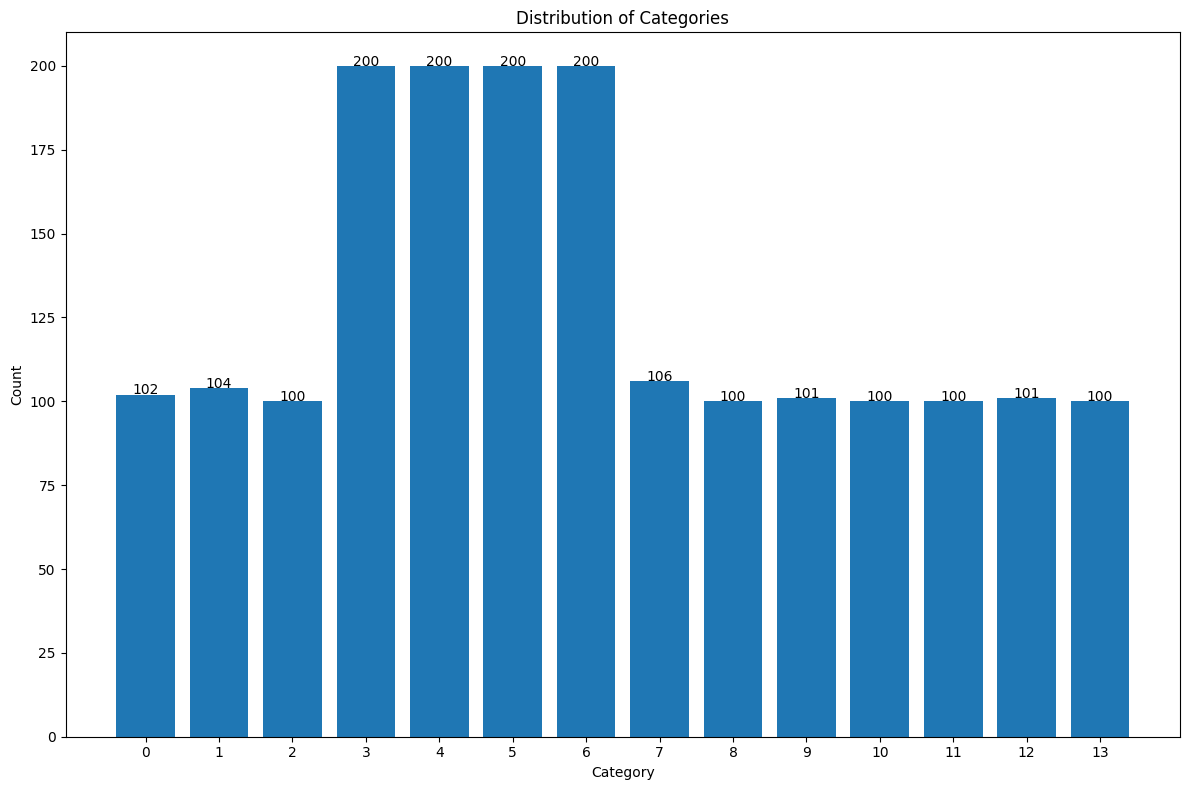

In [12]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [13]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=SEED
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 1451
Number of validation articles: 363


자유 [0]: 5.51%
학사 [1]: 6.06%
장학 · 행정 [2]: 5.44%
학교생활 [3]: 10.68%
수업 [4]: 10.89%
수업/이과 [5]: 10.34%
수업/문과 [6]: 11.37%
캠퍼스 [7]: 6.34%
취업 · 진로 [8]: 5.38%
일상생활 [9]: 5.86%
음식점 · 카페 [10]: 5.31%
취미 · 여가 [11]: 6.06%
인간관계 [12]: 5.44%
병역 [13]: 5.31%


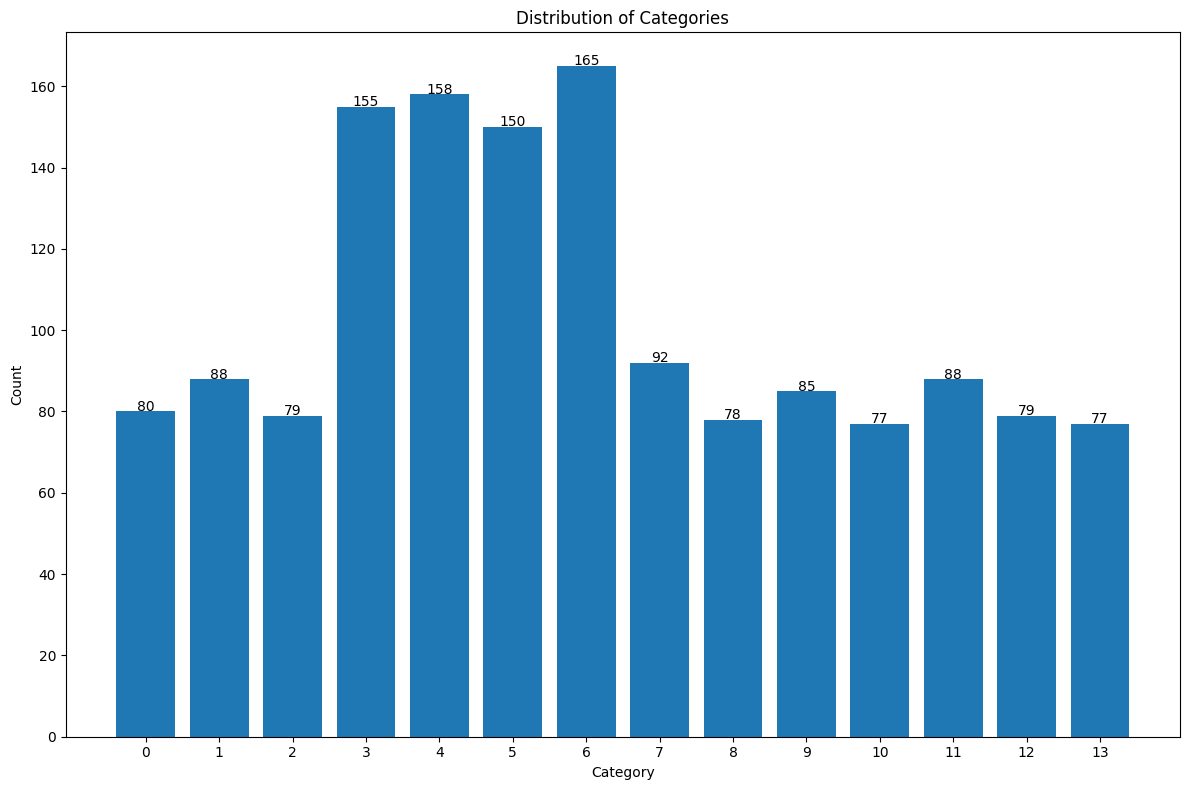

In [14]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 [0]: 6.06%
학사 [1]: 4.41%
장학 · 행정 [2]: 5.79%
학교생활 [3]: 12.40%
수업 [4]: 11.57%
수업/이과 [5]: 13.77%
수업/문과 [6]: 9.64%
캠퍼스 [7]: 3.86%
취업 · 진로 [8]: 6.06%
일상생활 [9]: 4.41%
음식점 · 카페 [10]: 6.34%
취미 · 여가 [11]: 3.31%
인간관계 [12]: 6.06%
병역 [13]: 6.34%


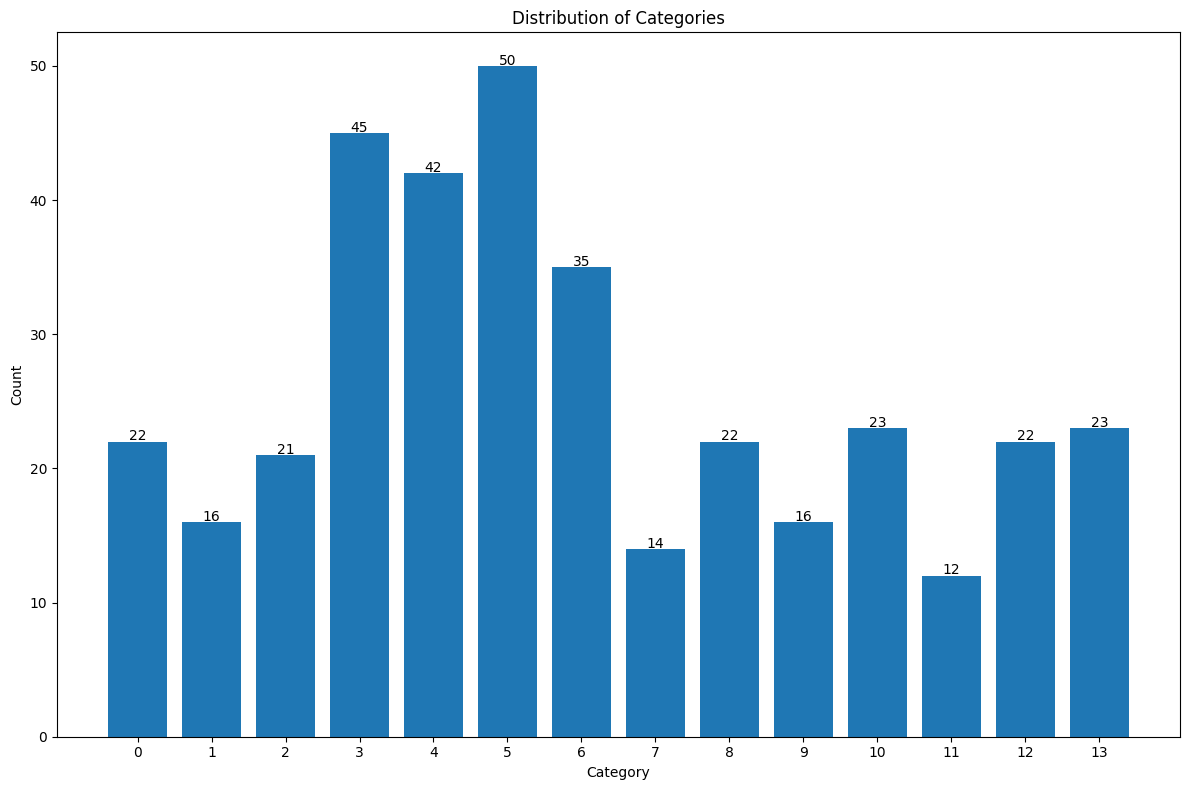

In [15]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [16]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID, do_basic_tokenize=False)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서
Tokenized: ['조은', '##문화', '##사', '몇', '##시에', '보통', '열리', '##나요', '?', '?', '1', '##교', '##시', '수업', '책', '찾아야', '##되서']


In [17]:
# 모델 로드

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [18]:
# 모델 세부 정보 수정

model.resize_token_embeddings(len(tokenizer))

Embedding(54343, 768, padding_idx=0)

In [19]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_772733/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_772733/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_772733/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_772733/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [20]:
# 학습 전 초기화

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

train_accs = []
train_precs = []
train_recs = []
train_f1s = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f1s = []
val_losses = []

In [21]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f1 = f1_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f1

In [22]:
# 학습 시작

early_stopping_counter = 0
best_val_f1 = 0.0
best_val_loss = float('inf')
best_model_paths = []

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f1s.append(train_f1)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f1s.append(val_f1)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F1 = {train_f1:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F1 = {val_f1:.4f}, Val Loss = {val_loss:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = os.path.join(SAVE_PATH, f'.model-epoch-{epoch + 1:02d}-{best_val_f1:.4f}')
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        best_model_paths.append(best_model_path)

        if len(best_model_paths) >= 6:
            model_path = best_model_paths.pop(0)
            os.system(f'rm -rf {model_path}')

        print(f'  Best model saved with {best_val_f1:.4f} F1 score.')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f'  Early stopping triggered after {epoch + 1} epochs')
            break

print('Training finished.')

Epoch 1 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.38it/s]


Epoch 1:
  Train Acc = 0.0717, Train Prec = 0.0725, Train Rec = 0.0717, Train F1 = 0.0500, Train Loss = 2.6379
  Val Acc = 0.1074, Val Prec = 0.0334, Val Rec = 0.1074, Val F1 = 0.0489, Val Loss = 2.6305
  Best model saved with 0.0489 F1 score.


Epoch 2 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.37it/s]


Epoch 2:
  Train Acc = 0.0751, Train Prec = 0.0770, Train Rec = 0.0751, Train F1 = 0.0529, Train Loss = 2.6268
  Val Acc = 0.1460, Val Prec = 0.0651, Val Rec = 0.1460, Val F1 = 0.0743, Val Loss = 2.6110
  Best model saved with 0.0743 F1 score.


Epoch 3 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.26it/s]


Epoch 3:
  Train Acc = 0.1137, Train Prec = 0.0864, Train Rec = 0.1137, Train F1 = 0.0655, Train Loss = 2.6051
  Val Acc = 0.1625, Val Prec = 0.0602, Val Rec = 0.1625, Val F1 = 0.0826, Val Loss = 2.5785
  Best model saved with 0.0826 F1 score.


Epoch 4 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.18it/s]


Epoch 4:
  Train Acc = 0.1413, Train Prec = 0.0834, Train Rec = 0.1413, Train F1 = 0.0843, Train Loss = 2.5782
  Val Acc = 0.2204, Val Prec = 0.0977, Val Rec = 0.2204, Val F1 = 0.1282, Val Loss = 2.5455
  Best model saved with 0.1282 F1 score.


Epoch 5 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.12it/s]


Epoch 5:
  Train Acc = 0.1881, Train Prec = 0.1367, Train Rec = 0.1881, Train F1 = 0.1146, Train Loss = 2.5408
  Val Acc = 0.2782, Val Prec = 0.1499, Val Rec = 0.2782, Val F1 = 0.1849, Val Loss = 2.4985
  Best model saved with 0.1849 F1 score.


Epoch 6 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.10it/s]


Epoch 6:
  Train Acc = 0.2212, Train Prec = 0.2205, Train Rec = 0.2212, Train F1 = 0.1431, Train Loss = 2.4786
  Val Acc = 0.2865, Val Prec = 0.1606, Val Rec = 0.2865, Val F1 = 0.1992, Val Loss = 2.4061
  Best model saved with 0.1992 F1 score.


Epoch 7 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.06it/s]


Epoch 7:
  Train Acc = 0.2984, Train Prec = 0.4247, Train Rec = 0.2984, Train F1 = 0.2221, Train Loss = 2.3451
  Val Acc = 0.3884, Val Prec = 0.5420, Val Rec = 0.3884, Val F1 = 0.3269, Val Loss = 2.2046
  Best model saved with 0.3269 F1 score.


Epoch 8 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.00it/s]


Epoch 8:
  Train Acc = 0.4762, Train Prec = 0.6214, Train Rec = 0.4762, Train F1 = 0.4425, Train Loss = 2.1151
  Val Acc = 0.6033, Val Prec = 0.6736, Val Rec = 0.6033, Val F1 = 0.5779, Val Loss = 1.8979
  Best model saved with 0.5779 F1 score.


Epoch 9 - Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 17.04it/s]


Epoch 9:
  Train Acc = 0.7119, Train Prec = 0.7365, Train Rec = 0.7119, Train F1 = 0.7037, Train Loss = 1.7579
  Val Acc = 0.7245, Val Prec = 0.7388, Val Rec = 0.7245, Val F1 = 0.7166, Val Loss = 1.5049
  Best model saved with 0.7166 F1 score.


Epoch 10 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.99it/s]


Epoch 10:
  Train Acc = 0.8249, Train Prec = 0.8287, Train Rec = 0.8249, Train F1 = 0.8215, Train Loss = 1.3474
  Val Acc = 0.7824, Val Prec = 0.7912, Val Rec = 0.7824, Val F1 = 0.7801, Val Loss = 1.1721
  Best model saved with 0.7801 F1 score.


Epoch 11 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.98it/s]


Epoch 11:
  Train Acc = 0.9083, Train Prec = 0.9097, Train Rec = 0.9083, Train F1 = 0.9079, Train Loss = 0.9588
  Val Acc = 0.8154, Val Prec = 0.8227, Val Rec = 0.8154, Val F1 = 0.8152, Val Loss = 0.8841
  Best model saved with 0.8152 F1 score.


Epoch 12 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.99it/s]


Epoch 12:
  Train Acc = 0.9593, Train Prec = 0.9593, Train Rec = 0.9593, Train F1 = 0.9592, Train Loss = 0.6307
  Val Acc = 0.8292, Val Prec = 0.8349, Val Rec = 0.8292, Val F1 = 0.8269, Val Loss = 0.7353
  Best model saved with 0.8269 F1 score.


Epoch 13 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.94it/s]


Epoch 13:
  Train Acc = 0.9855, Train Prec = 0.9856, Train Rec = 0.9855, Train F1 = 0.9855, Train Loss = 0.3998
  Val Acc = 0.8430, Val Prec = 0.8468, Val Rec = 0.8430, Val F1 = 0.8410, Val Loss = 0.6208
  Best model saved with 0.8410 F1 score.


Epoch 14 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.99it/s]


Epoch 14:
  Train Acc = 0.9917, Train Prec = 0.9917, Train Rec = 0.9917, Train F1 = 0.9917, Train Loss = 0.2555
  Val Acc = 0.8402, Val Prec = 0.8507, Val Rec = 0.8402, Val F1 = 0.8419, Val Loss = 0.5612
  Best model saved with 0.8419 F1 score.


Epoch 15 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.96it/s]


Epoch 15:
  Train Acc = 0.9897, Train Prec = 0.9897, Train Rec = 0.9897, Train F1 = 0.9896, Train Loss = 0.1782
  Val Acc = 0.8375, Val Prec = 0.8477, Val Rec = 0.8375, Val F1 = 0.8389, Val Loss = 0.5675


Epoch 16 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.92it/s]


Epoch 16:
  Train Acc = 0.9931, Train Prec = 0.9931, Train Rec = 0.9931, Train F1 = 0.9931, Train Loss = 0.1328
  Val Acc = 0.8237, Val Prec = 0.8414, Val Rec = 0.8237, Val F1 = 0.8248, Val Loss = 0.6511


Epoch 17 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.94it/s]


Epoch 17:
  Train Acc = 0.9959, Train Prec = 0.9959, Train Rec = 0.9959, Train F1 = 0.9959, Train Loss = 0.1039
  Val Acc = 0.8375, Val Prec = 0.8477, Val Rec = 0.8375, Val F1 = 0.8383, Val Loss = 0.6028


Epoch 18 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.93it/s]


Epoch 18:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0729
  Val Acc = 0.8402, Val Prec = 0.8549, Val Rec = 0.8402, Val F1 = 0.8399, Val Loss = 0.6305


Epoch 19 - Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 16.91it/s]


Epoch 19:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9965, Train Loss = 0.0636
  Val Acc = 0.8485, Val Prec = 0.8606, Val Rec = 0.8485, Val F1 = 0.8489, Val Loss = 0.6123
  Best model saved with 0.8489 F1 score.
  Early stopping triggered after 19 epochs
Training finished.


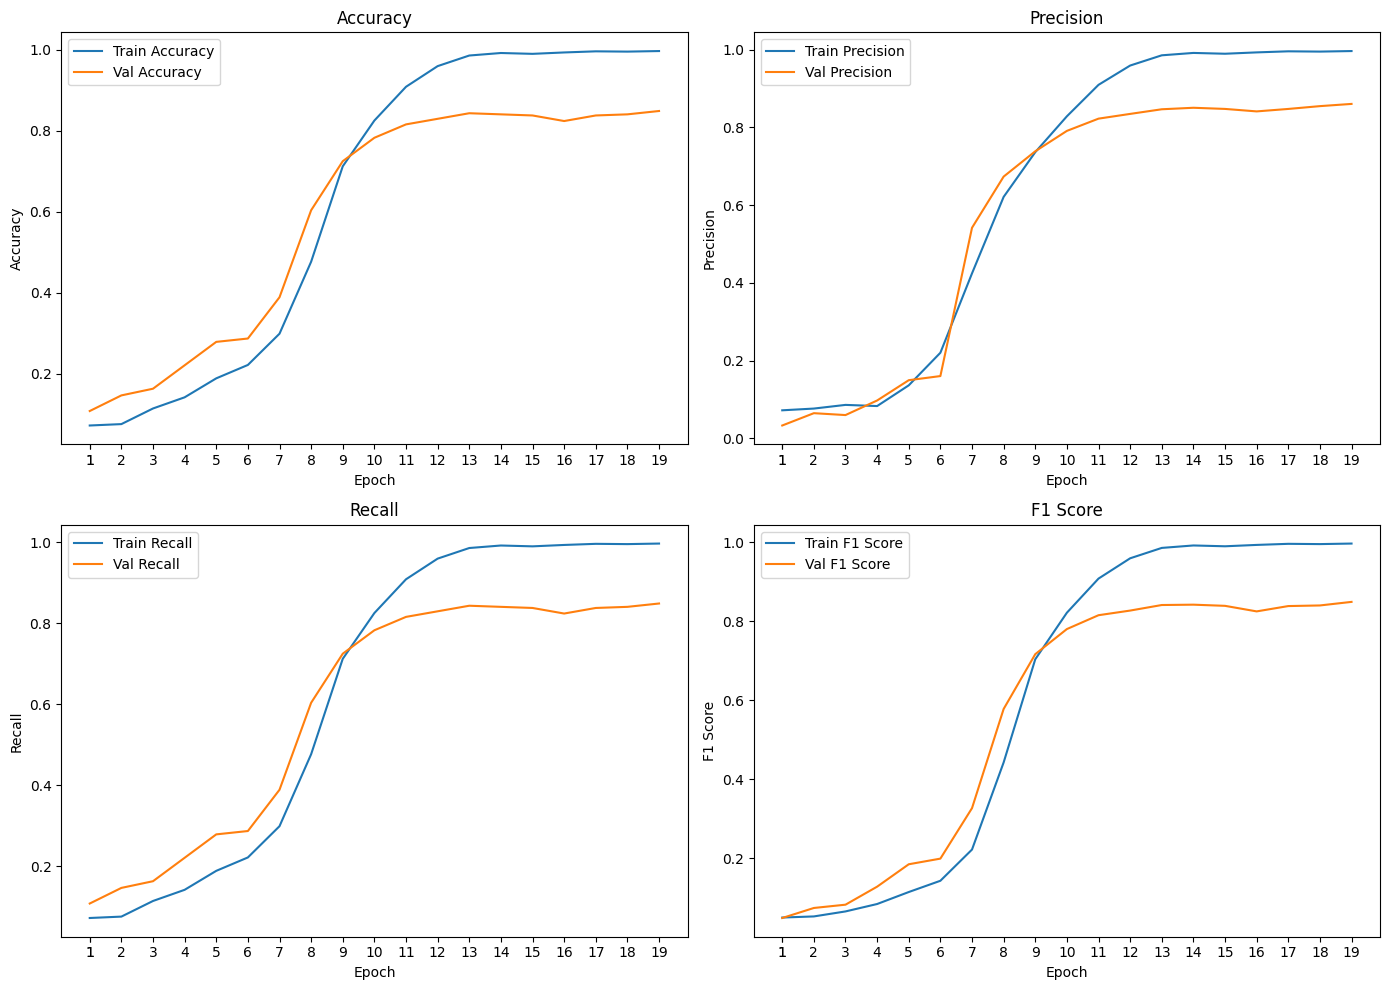

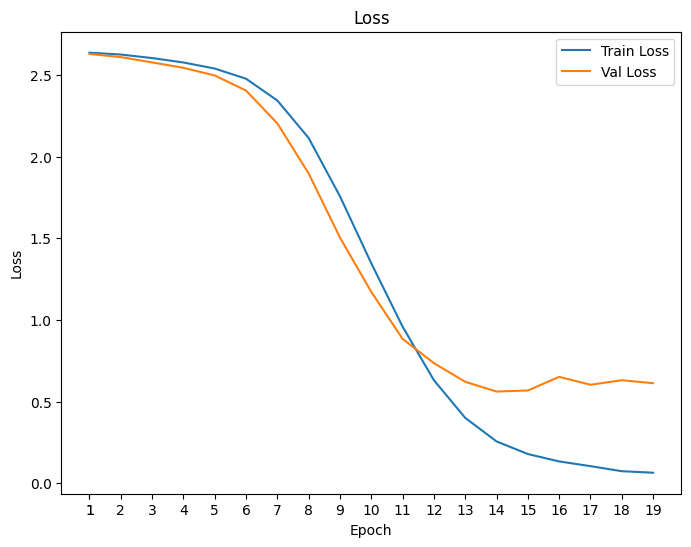

In [23]:
# 학습 결과 시각화

actual_epochs = len(train_losses)

if actual_epochs <= 20:
    step = 1
elif actual_epochs <= 50:
    step = 5
elif actual_epochs <= 100:
    step = 10
else:
    step = 20

epochs = range(1, actual_epochs + 1)
tick_marks = [1] + list(range(step, actual_epochs + 1, step))

plt.figure(figsize=(14, 10))

metrics = [
    ('Accuracy', train_accs, val_accs),
    ('Precision', train_precs, val_precs),
    ('Recall', train_recs, val_recs),
    ('F1 Score', train_f1s, val_f1s)
]

for i, (title, train_metric, val_metric) in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.plot(epochs[:len(train_metric)], train_metric, label=f'Train {title}')
    plt.plot(epochs[:len(val_metric)], val_metric, label=f'Val {title}')
    plt.xlabel('Epoch')
    plt.xticks(tick_marks)
    plt.ylabel(title)
    plt.legend()
    plt.title(title)

plt.tight_layout()
plt.savefig('metrics-plot.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.savefig('loss-plot.png')
plt.show()

In [24]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS)
model.to(device)

with open('../test-dataset.json', 'r', encoding='utf-8') as f:
    test_articles = json.load(f)

test_contents = [preprocess(article['content']) for article in test_articles]
test_labels = [article['label'] for article in test_articles]

test_encodings = tokenizer(
    test_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
test_input_ids = test_encodings['input_ids'].to(device)
test_attention_mask = test_encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    logits = outputs.logits
    test_predictions = torch.argmax(logits, dim=1).tolist()
    test_probabilities = torch.softmax(logits, dim=1).tolist()

test_acc, test_prec, test_rec, test_f1 = calculate_metrics(test_labels, test_predictions)

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_prec:.4f}')
print(f'Test Recall: {test_rec:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print()

for content, label, prediction, probs in zip(test_contents, test_labels, test_predictions, test_probabilities):
    true_category = CATEGORIES[label]
    predicted_category = CATEGORIES[prediction]
    probs_formatted = [f'{prob:.4f}' for prob in probs]

    if label == prediction and max(probs) >= 0.9:
        continue

    print(f'텍스트: {content}')
    print(f'실제 레이블: {true_category}')
    print(f'예측 레이블: {predicted_category} {probs_formatted}')
    print()

Best model path: ./.model-epoch-19-0.8489

Test Accuracy: 0.5333
Test Precision: 0.6637
Test Recall: 0.5333
Test F1 Score: 0.5435

텍스트: 나 아직 고학번이라고 할정도는 아닌데 군대갔다왔으면 졸업못한게 당연한 나이니까 화석은 아님 아무튼 아님
실제 레이블: 자유
예측 레이블: 병역 ['0.0017', '0.0014', '0.0043', '0.0007', '0.0024', '0.0010', '0.0004', '0.0010', '0.0031', '0.0091', '0.0007', '0.0005', '0.0015', '0.9724']

텍스트: 왜 가기싫은 학교에 가야하지? 왜냐면 가기싫은 직장에 다니기 위해서!
실제 레이블: 자유
예측 레이블: 병역 ['0.0332', '0.0988', '0.1098', '0.0132', '0.1812', '0.0040', '0.0033', '0.0309', '0.0258', '0.0163', '0.0036', '0.0029', '0.0054', '0.4716']

텍스트: 이제 병결은 출석처리 안되죠..? 모든수업
실제 레이블: 학사
예측 레이블: 수업 ['0.0018', '0.1262', '0.0017', '0.0017', '0.8554', '0.0027', '0.0015', '0.0024', '0.0009', '0.0007', '0.0007', '0.0010', '0.0008', '0.0025']

텍스트: 출튀하는법 새내기 시도할려합니다 어케해요
실제 레이블: 학교생활
예측 레이블: 일상생활 ['0.0037', '0.0006', '0.0025', '0.0010', '0.0075', '0.0020', '0.0012', '0.0147', '0.0057', '0.8898', '0.0042', '0.0034', '0.0385', '0.0252']

텍스트: 자바공부할건데 목표를 안드로이드로 갈까 웹서버로 갈까 자격증 ocjp 로